In [42]:
import os
import glob
import numpy as np
import pickle
import matplotlib.pyplot as plt
from coffea import processor
from coffea import util
from coffea.lookup_tools.dense_lookup import dense_lookup

# Lee todos los archivos .pkl en la carpeta
directorio = f"../outfiles/eff/2023-11-08/btag_eff/2017/mu/"
ext = "*.pkl"

archivos = glob.glob(directorio + ext)
Nombres = [os.path.splitext(os.path.basename(archivo))[0] for archivo in archivos]

archivos_dict = {}

for archivo in archivos:
    with open(archivo, "rb") as f:
        datos_archivo = pickle.load(f)
        archivos_dict[os.path.splitext(os.path.basename(archivo))[0]] = datos_archivo

# Obtén los histogramas y almacénalos en una lista
histogramas = [archivos_dict[nombre] for nombre in Nombres]

# Acumula los histogramas
btag_efficiency_hist = processor.accumulate(histogramas)

btag_efficiency_hist

Hist(
  StrCategory(['GluGluHToWWToLNuQQ', 'WZ', 'VBFHToWWTo2L2Nu', 'WW', 'DYJetsToLL_M-50_HT-400to600', 'DYJetsToLL_M-50_HT-600to800', 'ST_tW_antitop_5f_inclusiveDecays', 'WJetsToLNu_HT-200To400', 'DYJetsToLL_M-50_HT-800to1200', 'TTTo2L2Nu', 'DYJetsToLL_M-50_HT-1200to2500', 'WJetsToLNu_HT-100To200', 'VBFHToWWToLNuQQ', 'TTToHadronic', 'ST_s-channel_4f_leptonDecays', 'ST_tW_top_5f_inclusiveDecays', 'ST_t-channel_antitop_5f_InclusiveDecays', 'ZZ', 'WJetsToLNu_HT-1200To2500', 'WJetsToLNu_HT-600To800', 'ST_t-channel_top_5f_InclusiveDecays', 'WJetsToLNu_HT-2500ToInf', 'WJetsToLNu_HT-800To1200', 'DYJetsToLL_M-50_HT-200to400', 'DYJetsToLL_M-50_HT-100to200', 'DYJetsToLL_M-50_HT-2500toInf', 'TTToSemiLeptonic'], growth=True, name='dataset'),
  Variable([20, 30, 50, 70, 100, 140, 200, 300, 600, 1000], name='pt'),
  Regular(4, 0, 2.5, name='abseta'),
  IntCategory([0, 4, 5], name='flavor'),
  Regular(2, 0, 2, name='passWP'),
  storage=Double()) # Sum: 5306031217.0 (5311577784.0 with flow)

#### Now, let us accumulate all the samples and compute the efficiency

In [31]:
acc_btag_efficiency_hist = btag_efficiency_hist[{"dataset": sum}]
efficiency = acc_btag_efficiency_hist[{"passWP": True}] / acc_btag_efficiency_hist[{"passWP": sum}]

#### From this, we can create a lookup table

In [32]:
efflookup = dense_lookup(efficiency.values(), [ax.edges for ax in efficiency.axes]) 
efflookup

3 dimensional histogram with axes:
	1: [  20.   30.   50.   70.  100.  140.  200.  300.  600. 1000.]
	2: [0.    0.625 1.25  1.875 2.5  ]
	3: [0. 1. 2. 3.]

In [33]:
# Efficiency at 43 GeV, |eta|=0.2, for light, c, and b quark respectively
efflookup(43, 0.1, np.array([0, 1, 2]))

array([0.14524456, 0.51533174, 0.92859585])

#### Notice that hadron flavours (0, 4, 5) turn into (0, 1, 2). Let's modify them to their original values

In [34]:
efflookup._axes[-1] = np.array([0., 4., 5., 6.])

In [39]:
# Efficiency at 43 GeV, |eta|=0.2, for light, c, and b quark respectively
efflookup(1000, 2.2, np.array([0, 4, 5]))

array([0.52775794, 0.71423831, 0.93845971])

#### Let's visualize these efficiencies for the three flavors

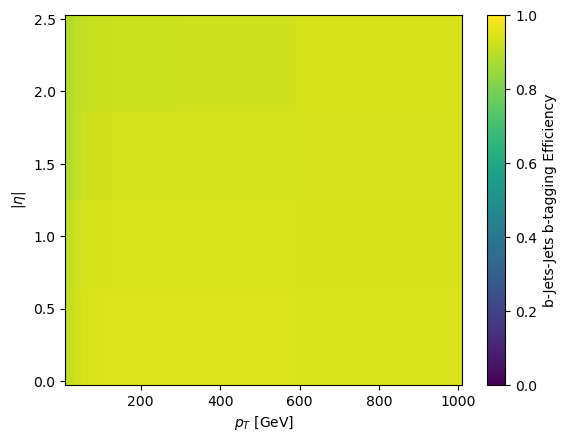

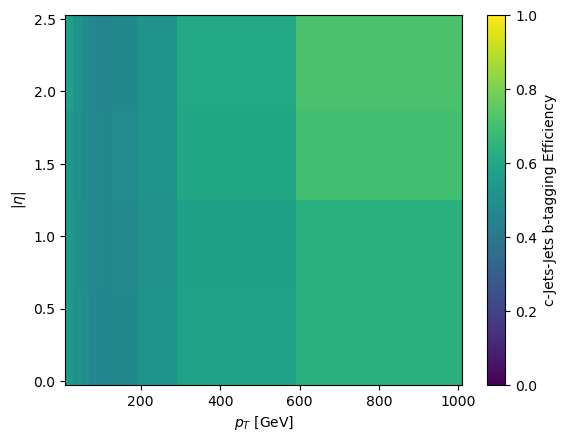

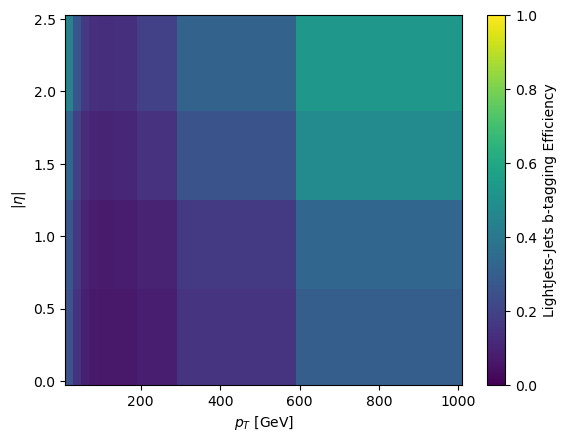

In [36]:
pts = np.linspace(20, 1000)
etas = np.linspace(0, 2.5)
pt, eta = np.meshgrid(pts, etas)

flavor_tags = {0: "LightJets", 4: "c-Jets", 5: "b-Jets"}
for i, flavor in enumerate([5, 4, 0]):
    fig, ax = plt.subplots()
    heatmap = ax.pcolormesh(pt, eta, efflookup(pt, eta, flavor), cmap='viridis', vmin=0, vmax=1)
    cbar = fig.colorbar(heatmap)
    ax.set_xlabel('$p_T$ [GeV]')
    ax.set_ylabel('$|\eta|$')
    cbar.set_label(f'{flavor_tags[flavor]}-Jets b-tagging Efficiency')

#### Let's save this efficiency lookup table for later use in the computation of the b-tagging weights

In [37]:
output_path = "../wprime_plus_b/btag_eff_deepJet_M_2017.coffea"
util.save(efflookup, output_path)

## Checking coffes files

In [120]:
from coffea import util

tagger = "deepJet"
wp = "M"
year = "2017"

# Ruta absoluta al archivo
file_path_old = "checking/btag_eff_deepJet_M_2017_old.coffea"
file_path_new = "checking/btag_eff_deepJet_M_2017_new.coffea"

# Cargar el archivo
efflookup_old = util.load(file_path_old)
efflookup_new = util.load(file_path_new)

#### Showing 2D histograms

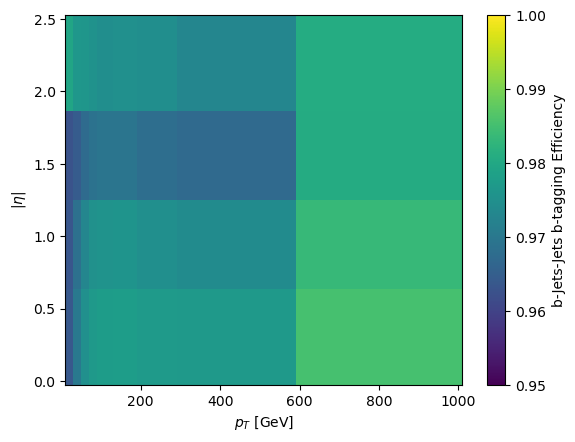

In [133]:
pts = np.linspace(20, 1000)
etas = np.linspace(0, 2.5)
pt, eta = np.meshgrid(pts, etas)

flavor_tags = {0: "LightJets", 4: "c-Jets", 5: "b-Jets"}

   
h1 = efflookup_new(pt, eta, 5)
h2 = efflookup_old(pt, eta, 5)

h = h1/h2 
fig, ax = plt.subplots()

heatmap = ax.pcolormesh(pt, eta, h, cmap='viridis', vmin=0.95, vmax=1.00)
cbar = fig.colorbar(heatmap)
ax.set_xlabel('$p_T$ [GeV]')
ax.set_ylabel('$|\eta|$')
cbar.set_label(f'{flavor_tags[5]}-Jets b-tagging Efficiency')